In [30]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import matplotlib.pyplot as plt
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

In [41]:
# the following function adds X gates to the quantum circuit qc for qubits with index in the (bit)string x0
# argument: qc quantum circuit, x0 (bit)string, n length of the bitstring = # of relevant qubits in circuit

def add_many_x(qc: QuantumCircuit, x0: str, n):
    for j in range(n):
        if x0[j] == '0':
            qc.x(j)
    return()

# the following function adds to a quantum circuit of n + 1 qubits a set of gates which implement an oracle unitary.
# the oracle unitary maps |x>|y> -> |x> (X|y>) for x = x0, |x>|y> -> |x>|y> for x \neq x0
# arguments: qc QuantumCircuit, n number of x qubits, x0 random int with 0 <= x0 <= 2**n-1

def add_random_marking_oracle(qc, n, x0):
    appo = '{' + f'0:0{n}b' + '}'
    x0 = appo.format(x0) #random bitstring "<2^n", type str
    # start with a flip on all qubits i with x0[i] = 0
    add_many_x(qc, x0, n)
#    qc.barrier()
    qc.mcx(list(range(n)), n)
#    qc.barrier()
    add_many_x(qc, x0, n)
    
    return()

# the following function adds to a quantum circuit of n + 1 qubits a set of gates which implement the unitary
# marking the maximally superposed state |psi0> = sum_x |x>.
# that is, |psi0>|y> -> |psi0>(X|y>) and |psi>|y> -> |psi>|y> for |psi> orthogonal to |psi0>
# argument: qc QuantumCircuit, n number of qubits for psi0

def add_psi0_marker(qc, n):
    for j in range(n):
        qc.h(j)
        qc.x(j)
    qc.mcx(list(range(n)), n)
    for j in range(n):
        qc.x(j)
        qc.h(j)
    return()

# ...similar to above, adds both oracle and unitary marking psi0
def add_grover_op(qc,n, x0):
    add_random_marking_oracle(qc, n, x0)
    add_psi0_marker(qc, n)

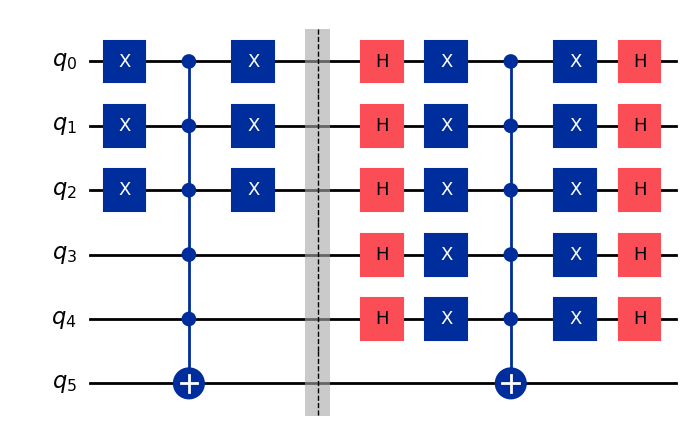

In [42]:
test_qc = QuantumCircuit(5+1)
add_random_marking_oracle(test_qc,5, 3)
test_qc.barrier()
add_psi0_marker(test_qc,5)
test_qc.draw('mpl')

Marked item has x0 =  1011000
Number of iterations needed =  8


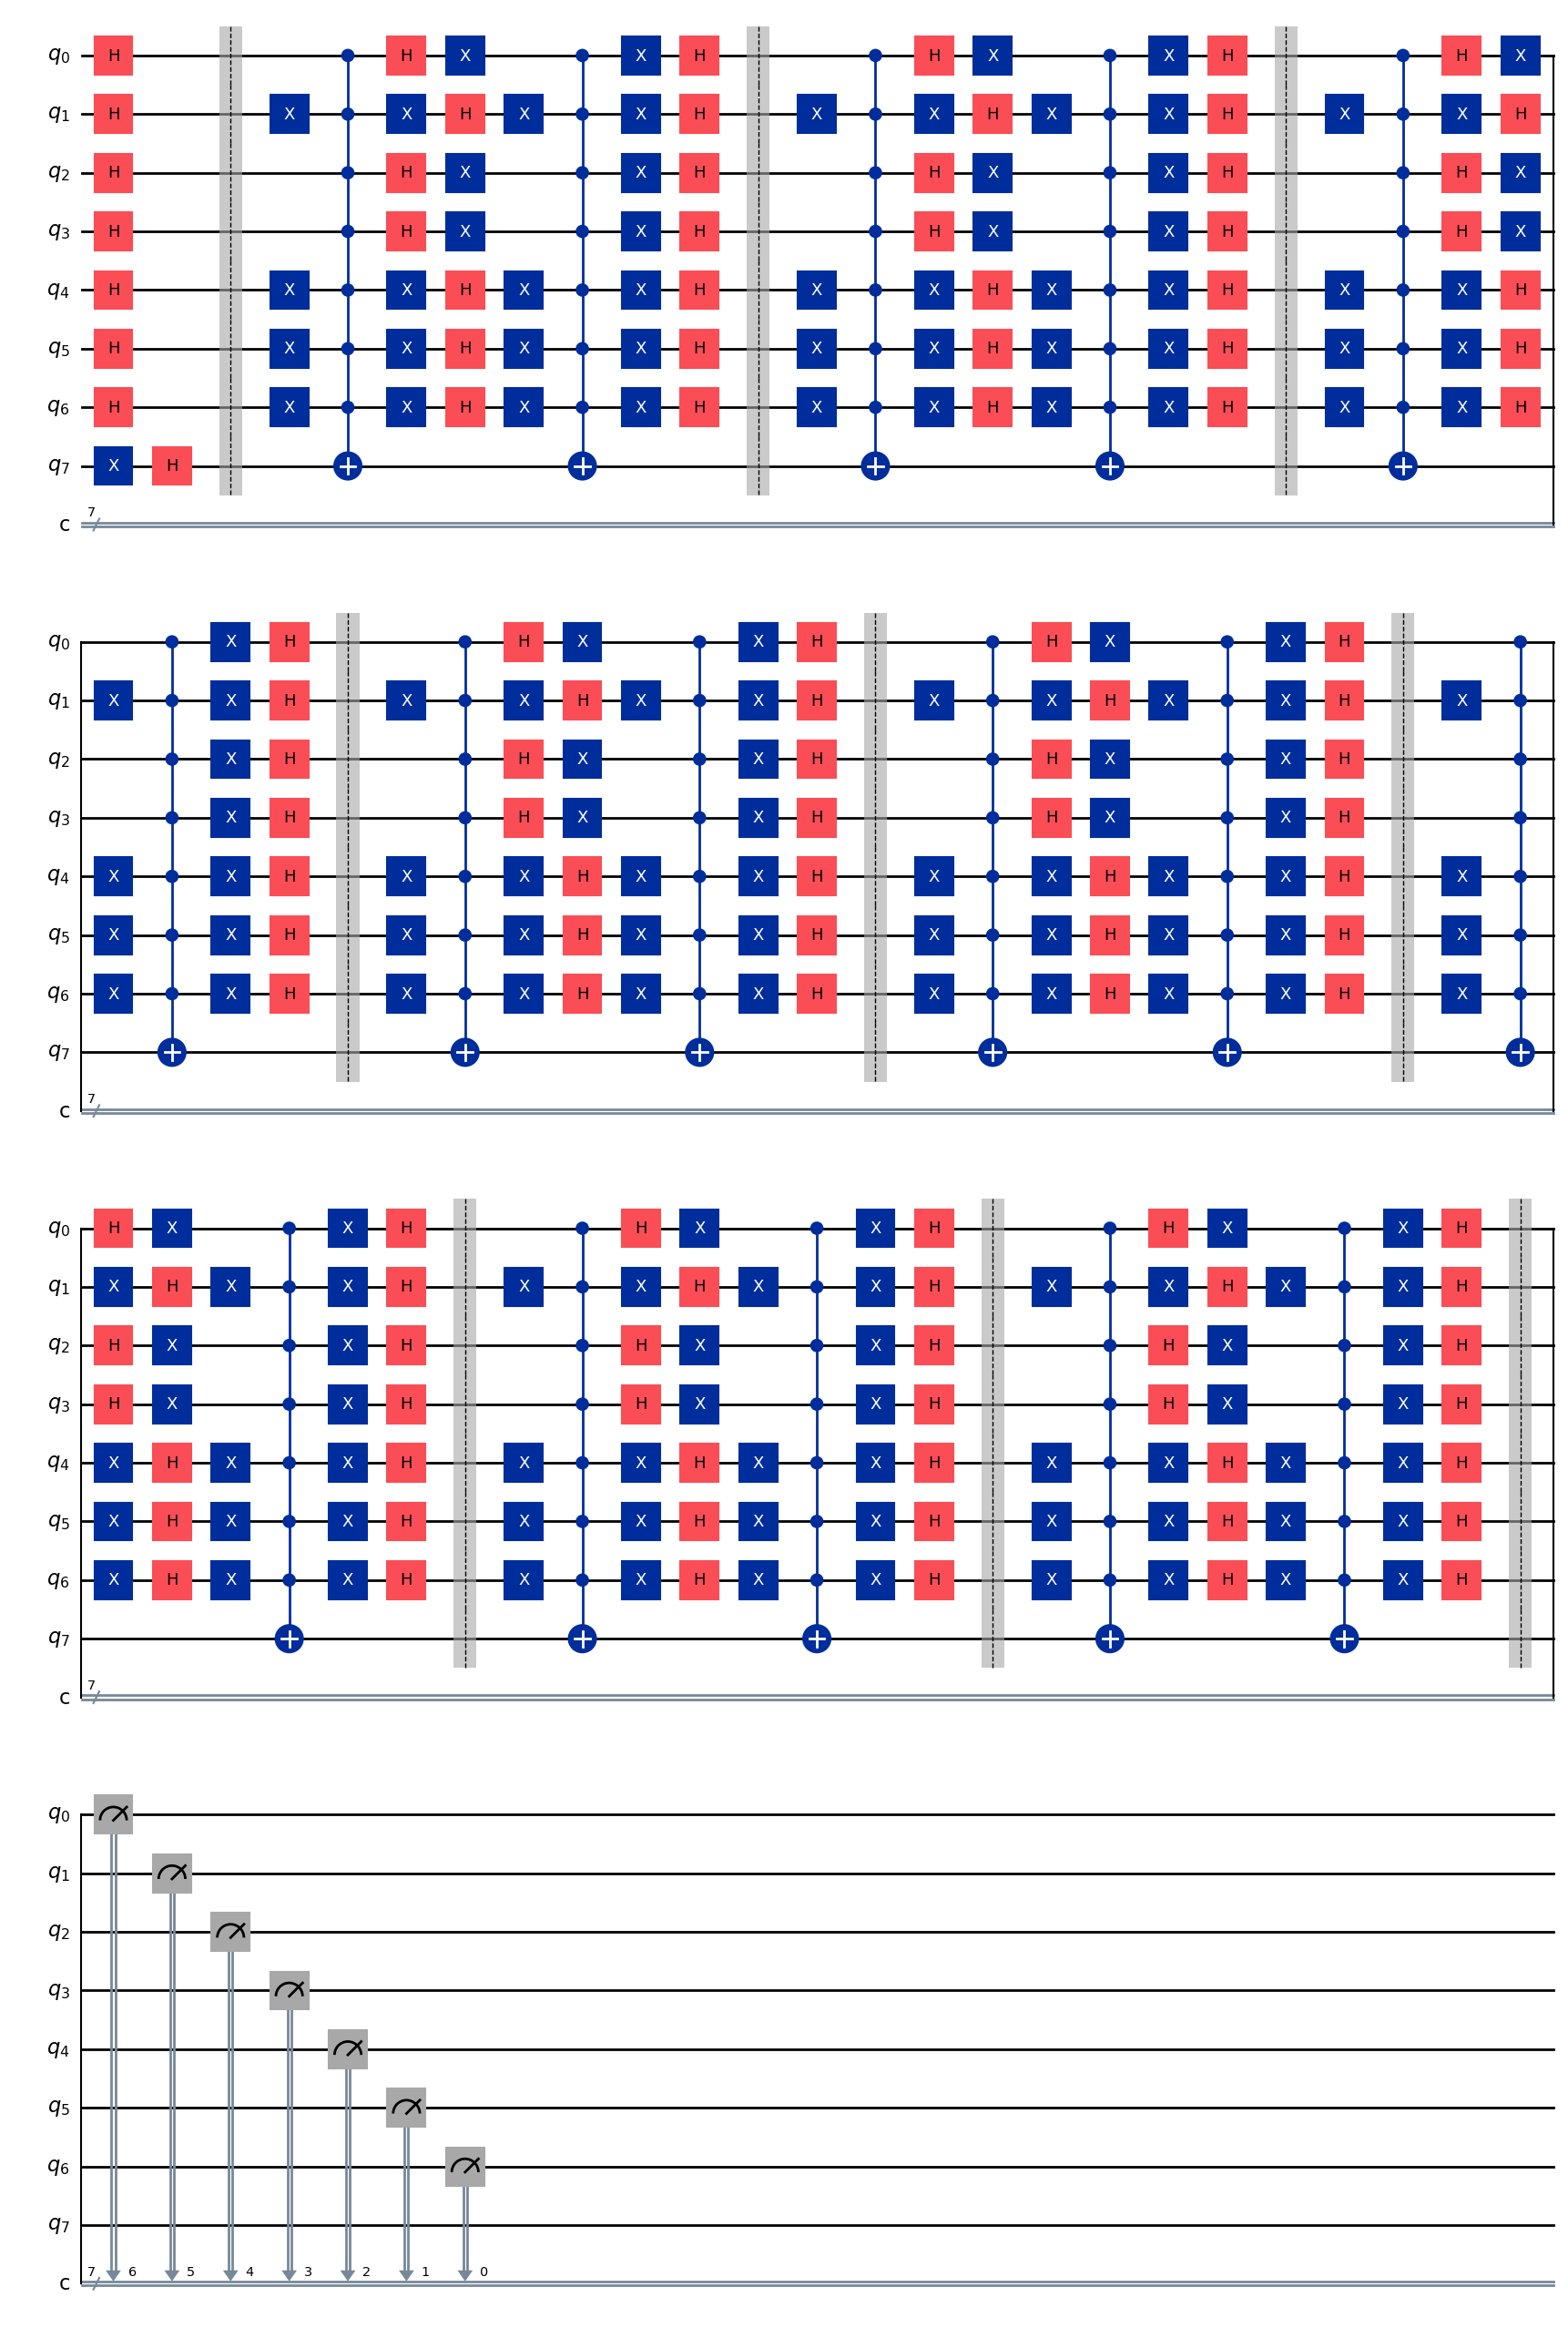

In [90]:
# now build the circuit for grover's search algorithm

n = 7
x0 = np.random.randint(0,2**n)
appo = '{' + f'0:0{n}b' + '}'
print("Marked item has x0 = ",appo.format(x0) )

grover_qc = QuantumCircuit(n+1,n)
#prepare initial state
for j in range(n):
    grover_qc.h(j)
grover_qc.x(n)
grover_qc.h(n)
grover_qc.barrier()

# number of grover operators needed
number_grover = int( (np.pi*2**(n/2 - 1.) - 1. )/2. )
print("Number of iterations needed = ",number_grover )

# add grover operators
for j in range(number_grover):
    add_grover_op(grover_qc,n, x0)
    grover_qc.barrier()

for j in range(n):
    grover_qc.measure(j,n-1-j)

grover_qc.draw(output = 'mpl')

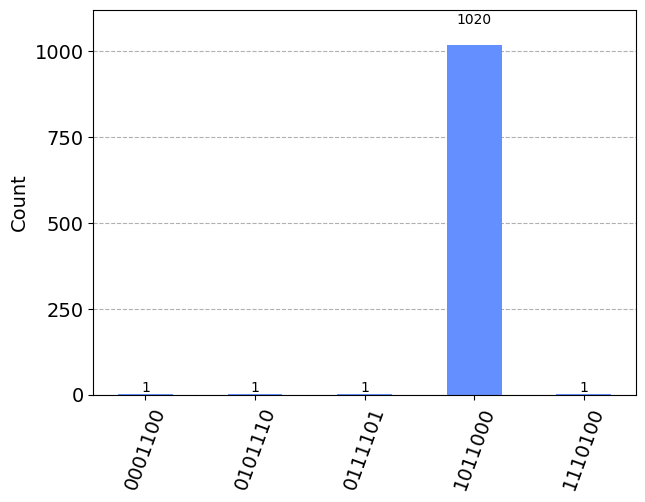

In [92]:
# finally simulate circuit operating: use circuit on input |0,....,0> and "measure" unknown number x0 (in binary notation)
# as the obtained bitstring of measurement outcomes. ...Repeat measurement, get measurement probabilities


# quasiprobabilities = theoretical values
# results = Sampler().run(grover_qc).result()
# statistics = results.quasi_dists[0].binary_probabilities()
# display(plot_histogram(statistics))

#sampling
result = AerSimulator().run(grover_qc).result()
statistics = result.get_counts()
display(plot_histogram(statistics))